# Метод классификации на основе машинного обучения для анализа NPS по опросам клиентов.
---

# Содержание
[Предпоготовка данных, загрузка библиотек](#Предпоготовка-данных,-загрузка-библиотек)  
[Работа с категориальными признаками](#Работа-с-категориальными-признаками)  
[Работа с численными признаками](#Работа-с-численными-признаками)  
[Обогащение внутренними данными](#Обогащение-внутренними-данными)  
[Обогащение данными из росстата.](#Обогащение-данными-из-росстата.)  
[Построение матрицы корреляций. Оценка зависимостей](#Построение-матрицы-корреляций.-Оценка-зависимостей)  

[К содержанию](#Содержание)
## Предпоготовка данных, загрузка библиотек

In [1]:
# Загрузка библиотек
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# чтение h2_20
df = pd.read_csv(
    r"P:\ЕКЦ\ОСК\Супервизор\Аналитики\Проекты\NPS\03_Данные в CSV\H2'20.csv",
    sep = ';',
    encoding='1251')
print(
f'''Кол-во респондентов: {df.shape[0]}
Кол-во признаков: {df.shape[1] - 2}''')

Кол-во респондентов: 6571
Кол-во признаков: 425


In [3]:
# исключение последнего пробел из названия столбцов
df.columns = [column.strip() for column in df.columns]

In [4]:
# удаление столбцов без значений
pust = df.describe().columns[df.describe().iloc[0] == 0]
print(f'Удалено пустых столбцов: {len(pust)}')
df = df.drop(columns=pust)

Удалено пустых столбцов: 47


In [5]:
# распределение в корзины по оценкам ШПД
def nps_bins(value):
    if value != value:
        return float('NaN')
    elif value <= 4:
        return 'super-detractors'
    elif value <= 6:
        return 'detractors'
    elif value <= 8:
        return 'passives'
    elif value <= 10:
        return 'promoters'
    else:
        raise Exception('некорректная оценка', value)
        
df['int_nps_bins'] = df['NPS ШПД'].apply(nps_bins)
df = df.dropna(subset=['int_nps_bins'])
df['int_nps_bins'].value_counts(normalize=True)

promoters           0.301834
passives            0.269097
detractors          0.224750
super-detractors    0.204319
Name: int_nps_bins, dtype: float64

In [6]:
# разбивка на категориальные и числовые серии
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print(
f'''Кол-во категориальных признаков: {len(categorical_columns)}
Кол-во числовых признаков: {len(numerical_columns)}''')

Кол-во категориальных признаков: 273
Кол-во числовых признаков: 108


[К содержанию](#Содержание)
## Работа с категориальными признаками

In [7]:
# удаление столбцов с одним значением
one_value = df[categorical_columns].describe().columns[
    df[categorical_columns].describe().iloc[1] == 1]
df = df.drop(columns=one_value)
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']

# удаление столбцов с кол-вом данных менее 5%
percentage = 0.07
threshold = percentage * len(df)
th_filter = df[categorical_columns].describe().columns[
    df[categorical_columns].describe().iloc[0] < threshold]
df = df.drop(columns=th_filter)
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']

print(
f'''Удалено столбцов с единственным значением: {len(one_value)}
Удалено столбцов с объёмом данных менее {round(percentage * 100)}%: {len(th_filter)}''')

Удалено столбцов с единственным значением: 31
Удалено столбцов с объёмом данных менее 7%: 102


In [8]:
# Исключение из анализа клиентов с технологией ADSL
mask_med = df['Технорлогия - кратко'] == 'Медь'
print(f'Исключено {len(df[mask_med])} строк c технологией ADSL')
df = df[~mask_med]
df = df.drop(columns=['Технорлогия - кратко'])
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']

Исключено 190 строк c технологией ADSL


In [9]:
# Значимые категориальные признаки
good_categorical_columns = [
    'date',
    'Технология',
    'Региональный филиал',
    'Пол респондента',
    'Оборудование ШПД_1 PON (октябрь)',
    'Форма доставки счёта',
    'int_nps_bins',
    ]

In [10]:
# Заполнение пропусков наиболее часто встречающимся значением
df['Оборудование ШПД_1 PON (октябрь)'] = df['Оборудование ШПД_1 PON (октябрь)'].fillna('HG8120H')

In [11]:
# Исключение незначимых категориальных признаков
list_difference = []
for item in categorical_columns:
    if item not in good_categorical_columns:
        list_difference.append(item)

df = df.drop(columns=list_difference)
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']

[К содержанию](#Содержание)
## Работа с численными признаками

In [12]:
th_filter = df[numerical_columns].describe().columns[
    df[numerical_columns].describe().iloc[1] == 0]
df = df.drop(columns=th_filter)
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']

print(f'Удалено столбцов с нулевыми значениями: {len(th_filter)}')

Удалено столбцов с нулевыми значениями: 22


In [13]:
# Объединение столбцов по размеру индексации в единый признак
ind_columns = []
for column in numerical_columns:
    if 'Размер индексации' in column:
        ind_columns.append(column)
df[ind_columns] = df[ind_columns].fillna(0)
df['ind'] = df[ind_columns].sum(axis=1)
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']

In [14]:
# Объединение столбцов доп. услуг
gop_stop_columns = [
    'Антивирус_2020',
    'ПУ "Оптимальный" тест-драйв_2020',
    'ПУ "Трансформер" тест-драйв_2020',
    'УП тест-драйв_2020'
    ]
df['dop_services'] = df[gop_stop_columns].sum(axis=1)
df['dop_services'] = df['dop_services'].apply(lambda x: 1 if x > 0 else 0)
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']

In [15]:
# Объединение столбцов по стоимости аренды
arenda_columns = []
for column in numerical_columns:
    if 'стоимость аренды' in column:
        arenda_columns.append(column)
df[arenda_columns] = df[arenda_columns].fillna(0)        
df['arenda'] = df[arenda_columns].sum(axis=1)
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']

In [16]:
# Значимые числовые признаки
good_numerical_columns = [
    'id_abon',
    'Возраст',
    'Номер абонента ШПД',
    'кол-во попаданий в ГП по критериям (деградация более 1 ч и недоступность более 30)',
    'Кол-во обращений',
    'ind',
    'dop_services',
    'arenda',
    ]

In [17]:
# заполнение пустых значений
df['Кол-во обращений'] = df['Кол-во обращений'].fillna(0)

In [18]:
# Исключение незначимых числовых признаков
list_difference = []
for item in numerical_columns:
    if item not in good_numerical_columns:
        list_difference.append(item)

df = df.drop(columns=list_difference)
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']

[К содержанию](#Содержание)
## Обогащение-внутренними-данными

In [19]:
# Удаление дубликатов по НЛС (Зачем 2 опроса по одному клиенту?)
df = df.sort_values(['id_abon', 'date'])
df = df.drop_duplicates(subset=['id_abon'])

In [20]:
# Загрузка df с доп. данными и объединение
add_df = pd.read_excel(r'P:\ЕКЦ\ОСК\Супервизор\Аналитики\Проекты\NPS\04_Очищенные данные\NWDATA-1485 Заготовка для наполнения данными.xlsx')
add_df = add_df.drop(columns='date')
df = df.merge(add_df, how='left', on='id_abon')

In [21]:
# Преобразование данных, заполнение пропусков
df.at[df['Наличие ОТА'] == 'Да', 'Наличие ОТА'] = 1
df.at[df['Наличие ШПД'] == 'Да', 'Наличие ШПД'] = 1
df.at[df['Наличие КТВ'] == 'Да', 'Наличие КТВ'] = 1
df.at[df['Наличие IPTV'] == 'Да', 'Наличие IPTV'] = 1

df = df.dropna(subset=['Наличие ШПД'])
df[['Наличие ОТА', 'Наличие ШПД', 'Наличие КТВ', 'Наличие IPTV', 
    'Разовый счет - Ежемесячный платеж по рассрочке (при наличии)']] = df[[
    'Наличие ОТА', 'Наличие ШПД', 'Наличие КТВ', 'Наличие IPTV',
    'Разовый счет - Ежемесячный платеж по рассрочке (при наличии)']].fillna(0)

df['Наличие ИТВ'] = (df['Наличие КТВ'] + df['Наличие IPTV']).apply(lambda x: 1 if x > 0 else 0)

median_traffic = df.describe()['ШПД 1 - объем трафика за предыдущие 30 дней']['50%']
print('Медианное значение трафика:', median_traffic)
print('Принятое значение для скорости ШПД: 100 Мб/с')

df['ШПД 1 - Скорость по тарифу'] = df['ШПД 1 - Скорость по тарифу'].fillna(100000)
df['ШПД 1 - объем трафика за предыдущие 30 дней'] = df[
    'ШПД 1 - объем трафика за предыдущие 30 дней'].fillna(164.6)

df['date'] = pd.to_datetime(df['date'], format=r'%d.%m.%Y %H:%M')
df['Срок жизни'] = (df['date'] - df['ШПД 1 - Дата подключения услуги']).dt.days

# Суммируем аренду и раасрочку для оптимизации
df['Стоимость оборудования'] = df[
    'Разовый счет - Ежемесячный платеж по рассрочке (при наличии)'] + df['arenda']

# Удаление лишних столбцов
df = df.drop(columns=[
    'Наличие КТВ', 'Наличие IPTV', 
    'ШПД 1 - Дата подключения услуги', 
    'date', 'Номер абонента ШПД',
    'Разовый счет - Ежемесячный платеж по рассрочке (при наличии)',
    'arenda',
    'Форма доставки счёта',
    ])

Медианное значение трафика: 164.660918285073
Принятое значение для скорости ШПД: 100 Мб/с


In [22]:
# Переименование столбцов
df = df.rename(columns={
    'id_abon': 'nls',
    'Технология': 'tech',
    'Региональный филиал': 'branch',
    'Возраст': 'age',
    'Пол респондента': 'gender',
    'Оборудование ШПД_1 PON (октябрь)': 'device_name',
    'кол-во попаданий в ГП по критериям (деградация более 1 ч и недоступность более 30)': 'incident_count',
    'Кол-во обращений': 'appeal_count',
    'int_nps_bins': 'nps_bins',
    'ind': 'ind',
    'dop_services': 'promo_action',
    'Наличие ОТА': 'TEL',
    'Наличие ШПД': 'INT',
    'Все услуги (в т.ч. доп.опции) - стоимость в месяц': 'service_revenue',
    'ШПД 1 - Скорость по тарифу': 'speed',
    'ШПД 1 - объем трафика за предыдущие 30 дней': 'traffic',
    'Наличие ИТВ': 'DTV',
    'Срок жизни': 'life_time',
    'Стоимость оборудования': 'device_revenue',
    })

[К содержанию](#Содержание)
## Обогащение данными из росстата.

In [23]:
# Выделение субъектов Федерации из префикса НЛС
region_mapping = {
    '22901': 'Архангельская область',
    '23501': 'Вологодская область',
    '23901': 'Калининградская область',
    '21001': 'Республика Карелия',
    '21101': 'Республика Коми',
    '25101': 'Мурманская область',
    '25301': 'Новгородская область',
    '26001': 'Псковская область',
    '27801': 'Санкт-Петербург',
    '24701': 'Ленинградская область',
    }
df['region'] = df['nls'].astype(str).str[:5].map(region_mapping)

In [24]:
# Загрузка данных с росстат и "Вижу Всё" (абонентская база)
rosstat_df = pd.read_excel(
    r"P:\ЕКЦ\ОСК\Супервизор\Аналитики\Проекты\NPS\Внешние данные из Росстата.xlsx")
for column in rosstat_df.columns[3:]:
    print(column)

Площадь, км²
Население, чел.  (оценка, 2021)
ВРП, млрд.руб. (2016)
ВРП на душу населения, тыс.руб./чел. (2016)
Среднедушевые денежные доходы населения (в месяц; рублей) (2019)
Коэффициент фондов (соотношение денежных доходов 10% наиболее и 10% наименее обеспеченного населения) (2020)
Число абонентов фиксированного широкополосного доступа к сети Интернет на 100 человек населения
Число абонентов фиксированного широкополосного доступа к сети Интернет, все провайдеры
Абонентская база ШПД Ростелеком (Вижу Всё)
Доля рынка ШПД Ростелеком (расчет)
ARPU за доступ к сети Интернет, месяц, все провайдеры (2020)


In [25]:
rosstat_df = rosstat_df.rename(columns={
    'Площадь, км²': 'region_area',
    'Население, чел.  (оценка, 2021)': 'region_population',
    'ВРП, млрд.руб. (2016)': 'region_VRP',
    'ВРП на душу населения, тыс.руб./чел. (2016)': 'region_VRP_by_person',
    'Среднедушевые денежные доходы населения (в месяц; рублей) (2019)': 'region_avg_income_by_person',
    'Коэффициент фондов (соотношение денежных доходов 10% наиболее и 10% наименее обеспеченного населения) (2020)': 'region_rich_poor_ratio',
    'Число абонентов фиксированного широкополосного доступа к сети Интернет на 100 человек населения': 'region_int_density',
    'Число абонентов фиксированного широкополосного доступа к сети Интернет, все провайдеры': 'region_int_count',
    'Абонентская база ШПД Ростелеком (Вижу Всё)': 'region_rtk_int_count',
    'Доля рынка ШПД Ростелеком (расчет)': 'region_rtk_int_percent',
    'ARPU за доступ к сети Интернет, месяц, все провайдеры (2020)': 'region_ARPU',
    })

In [26]:
# Объединение дадасетов
df = df.merge(rosstat_df, how='left', left_on='region', right_on='Субъект Федерации')
df = df.drop(columns=[
    'Субъект Федерации', 'Филиал', 'region_VRP', 
    'region_rtk_int_count', 'region_int_count', '№', 'INT'])

[К содержанию](#Содержание)
## Построение матрицы корреляций. Оценка зависимостей

In [27]:
df_corr = df.drop(columns=['nls', 'region_area', 'region_population'])

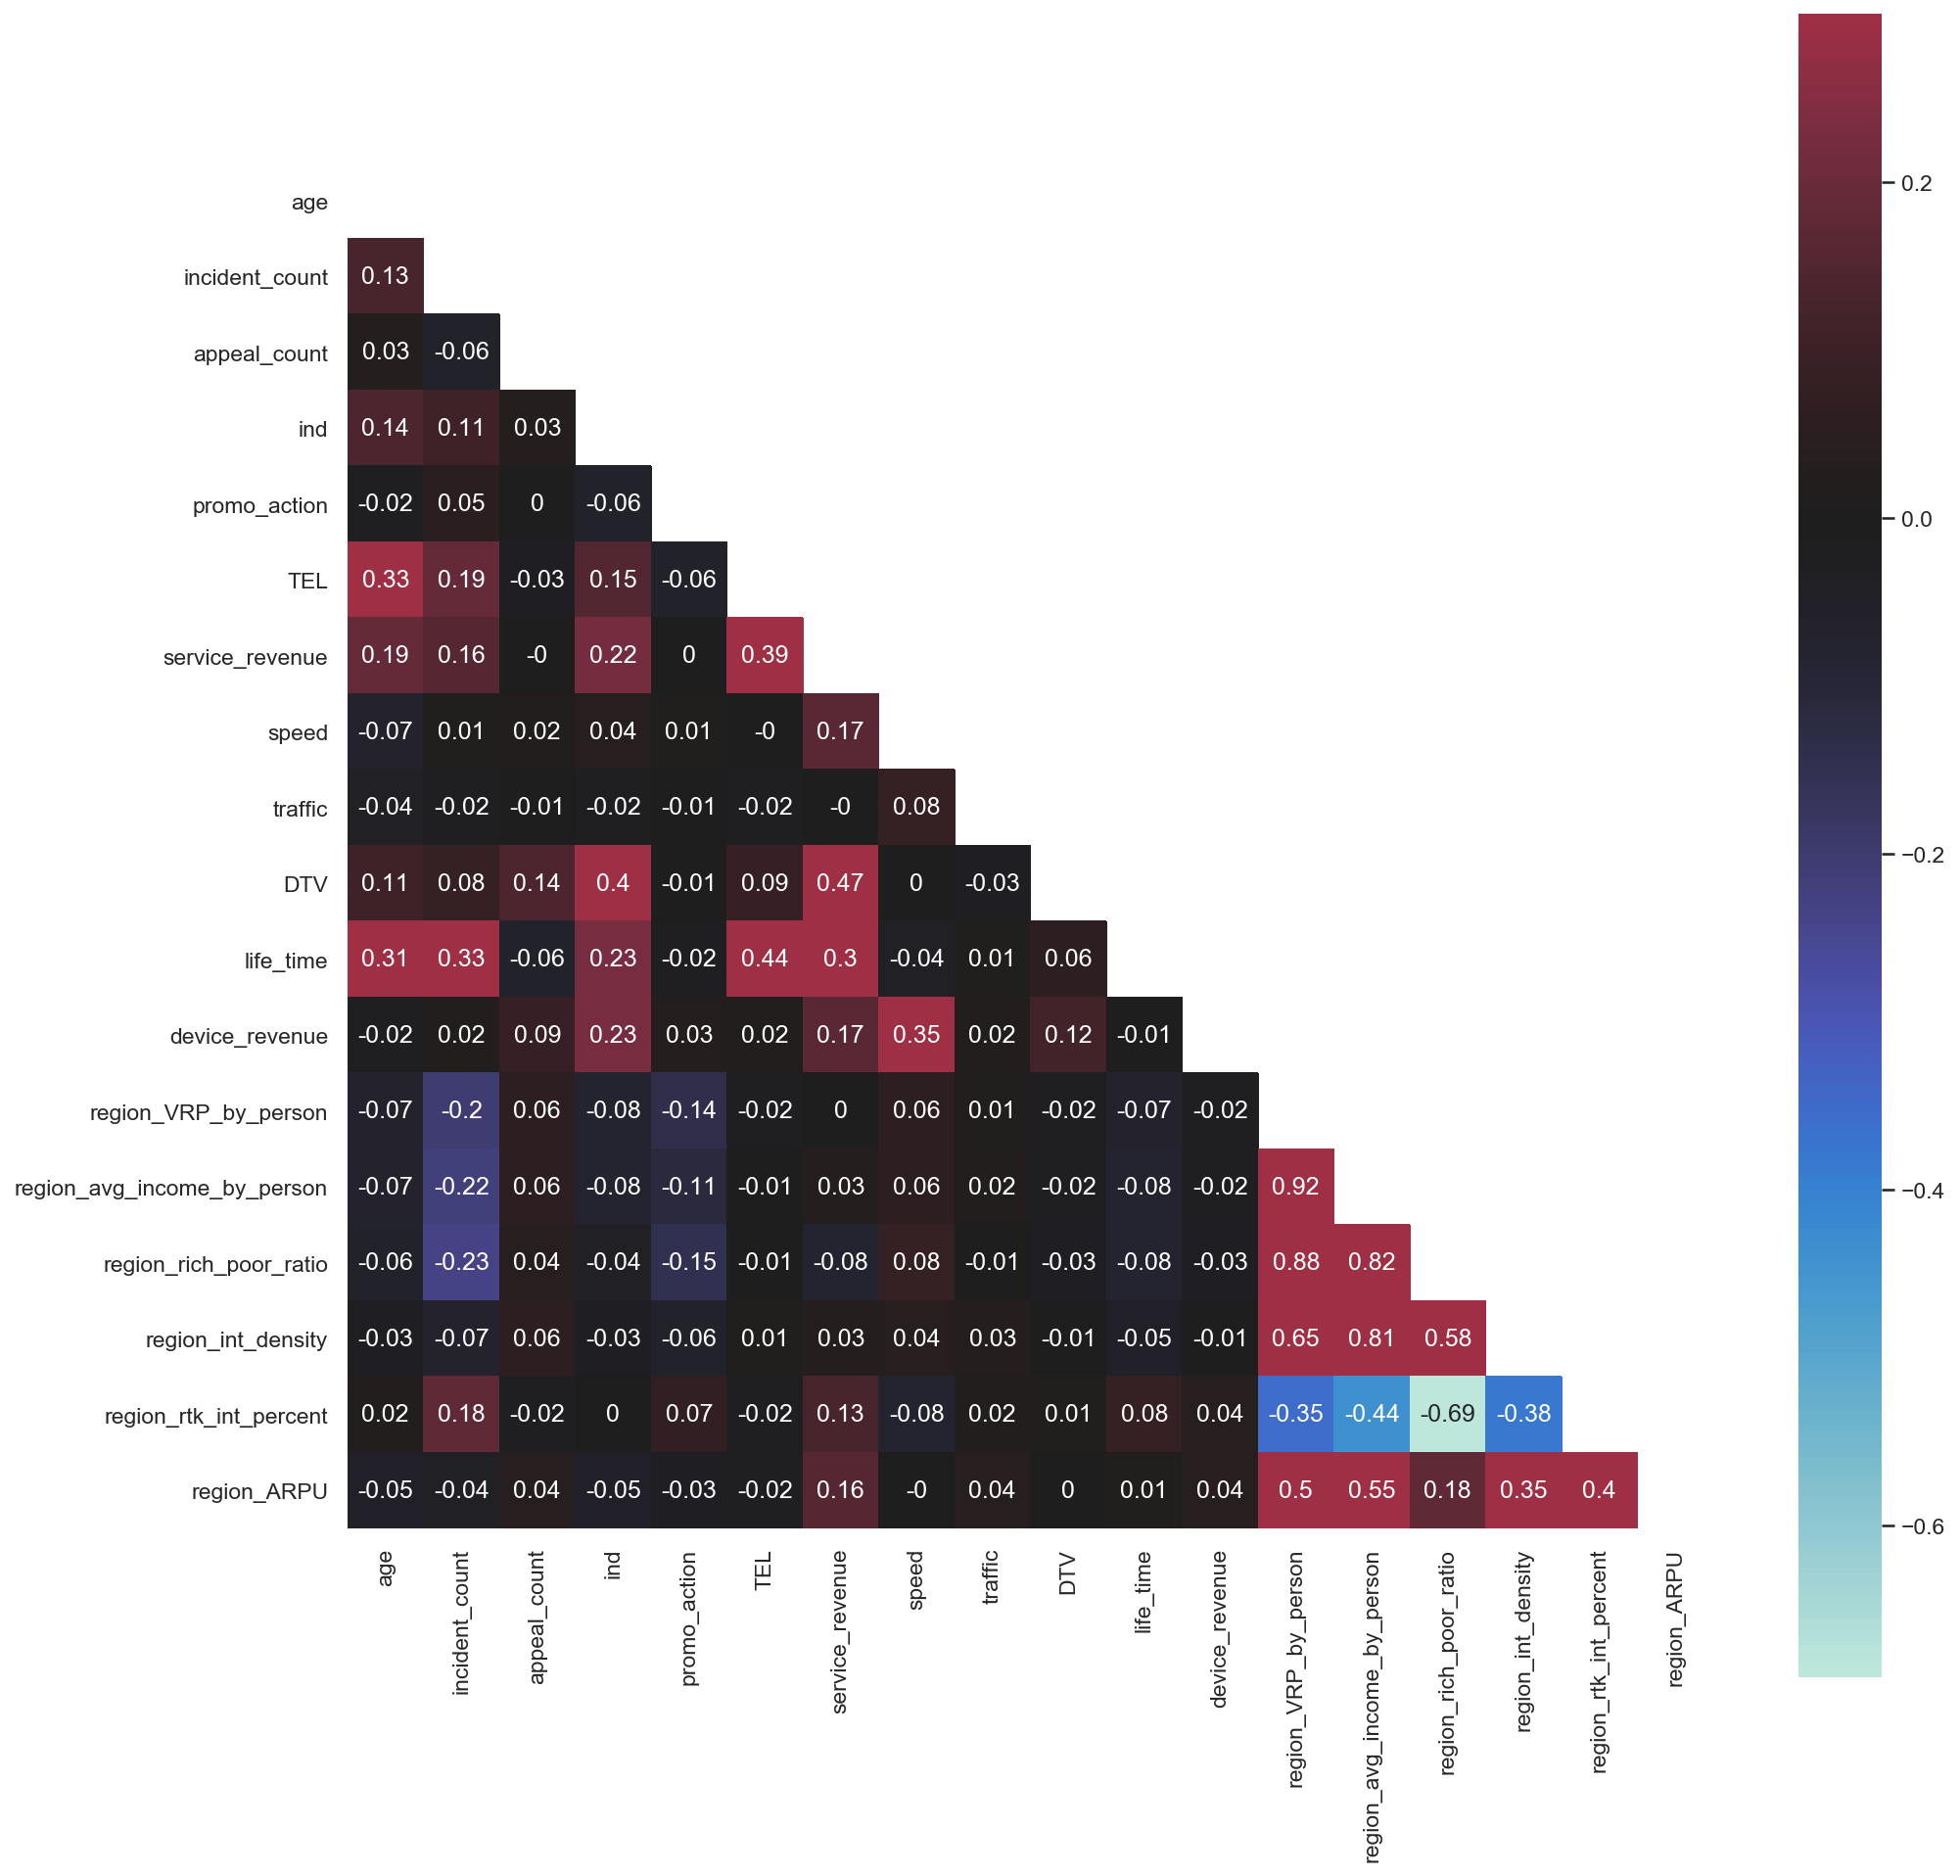

In [28]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
corr = df_corr.corr().round(2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, center=0)
    ax.set_ylim(len(corr.columns), 0)